# Walmart Sales Model

In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.4)
import itertools
import warnings
import datetime

warnings.filterwarnings("ignore")
import time

In [2]:
# Sklearn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    LabelEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [3]:
# Read csv
df = pd.read_csv(r"C:\Users\maxch\Downloads\Walmart_Sales.csv")
#Find missing and duplicate values
print(" MISSING VALUES:")
print(df.isna().sum())
print("")
print(
    f"Duplicates : {df.duplicated().sum()}, ({np.round(100*df.duplicated().sum()/len(df),1)}%)"
)


 MISSING VALUES:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Duplicates : 0, (0.0%)


In [4]:
#Split into training, test sets
train, test = train_test_split(df, test_size=0.2)
# Find shape
print("Train set shape:", train.shape)
print("Test set shape:", test.shape)

train.head()

Train set shape: (5148, 8)
Test set shape: (1287, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6167,44,11-06-2010,296818.20,0,65.24,2.841,126.111903,7.972
4747,34,20-08-2010,985152.94,0,76.45,2.671,126.076645,9.816
2924,21,29-04-2011,783250.75,0,70.19,3.810,215.277268,7.931
4404,31,13-04-2012,1407842.91,0,69.03,3.891,221.148403,6.891
2157,16,30-04-2010,383550.93,0,37.75,2.766,189.575127,6.842


Data set is well formatted without any missing values

In [5]:
train.nunique()

Store             45
Date             143
Weekly_Sales    5148
Holiday_Flag       2
Temperature     3120
Fuel_Price       879
CPI             1935
Unemployment     349
dtype: int64

In [6]:
train.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

Date is the only non number but that will likely be converted into day,month,year and dropped

Exploratory Data Analysis

<Axes: xlabel='Weekly_Sales', ylabel='Count'>

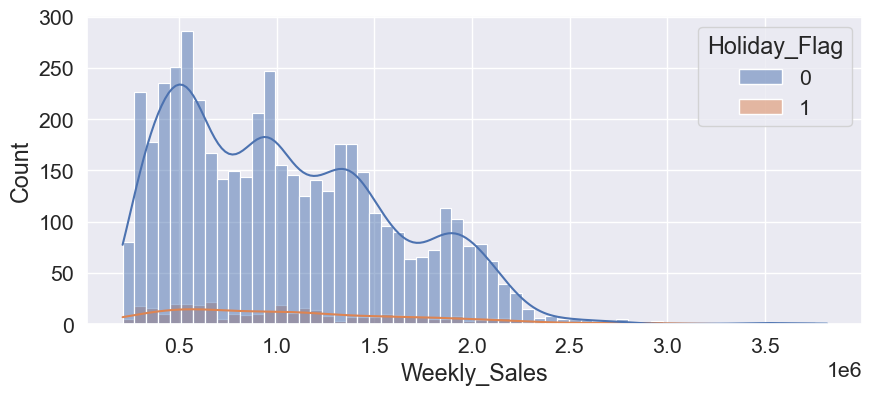

In [7]:
# Figure size
plt.figure(figsize=(10, 4))

# Histogram
sns.histplot(data=train, x="Weekly_Sales", hue="Holiday_Flag", bins=60, kde=True)

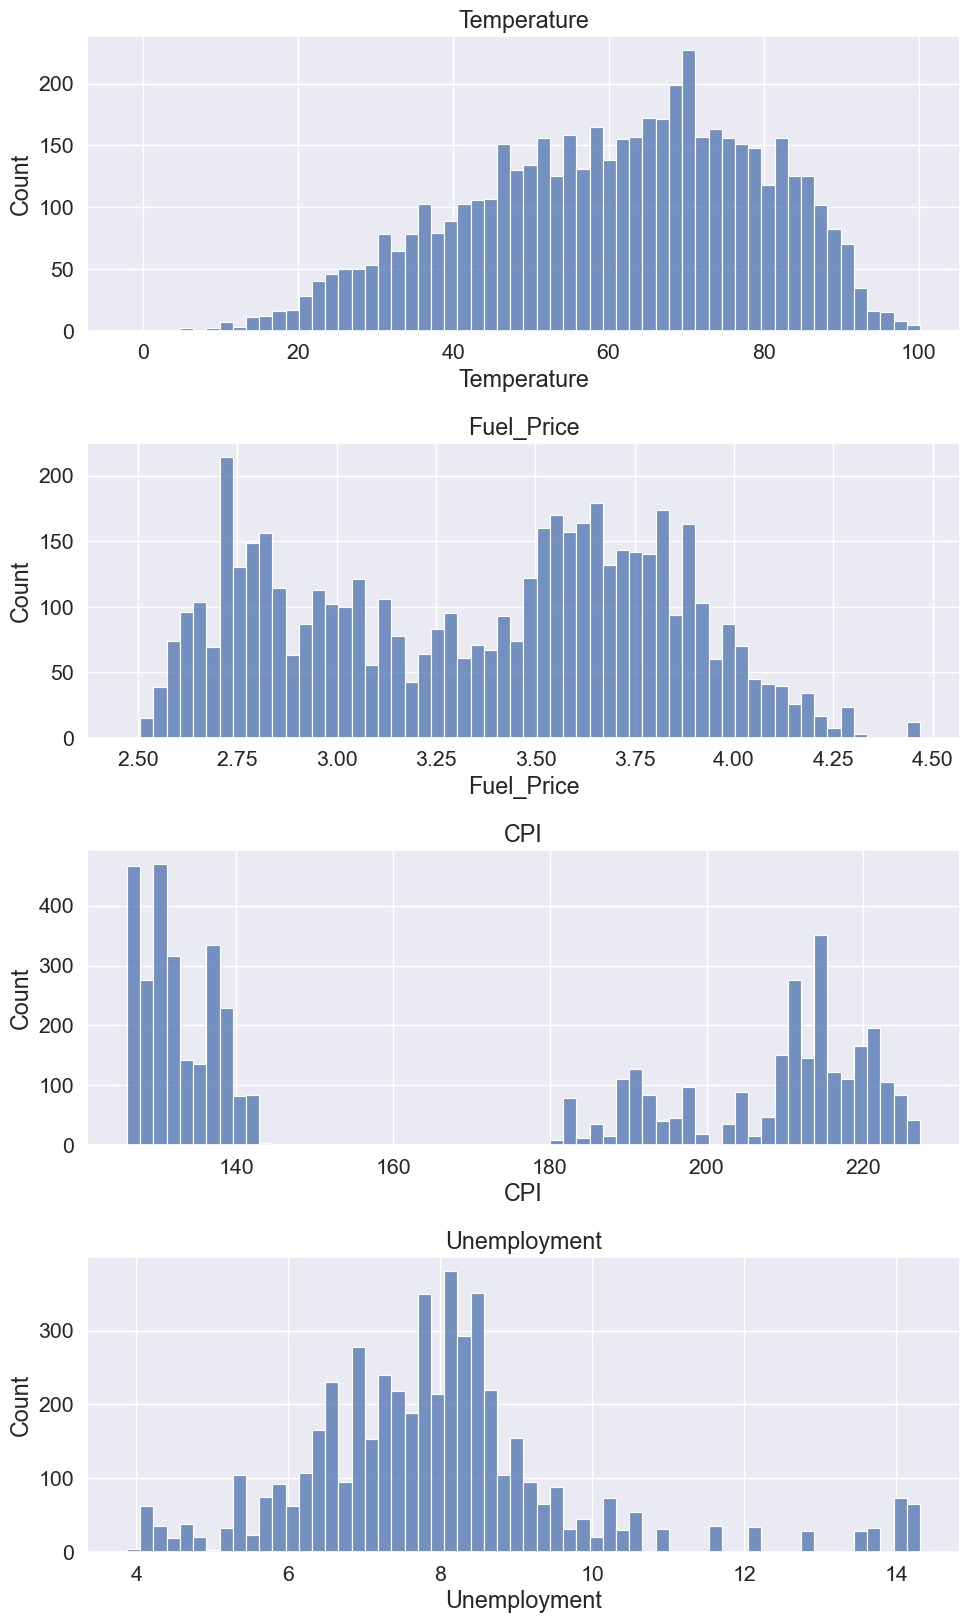

In [8]:
# Expenditure features
exp_feats = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

# Plot expenditure features
fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax = fig.add_subplot(5, 1, i + 1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=60, kde=False)
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

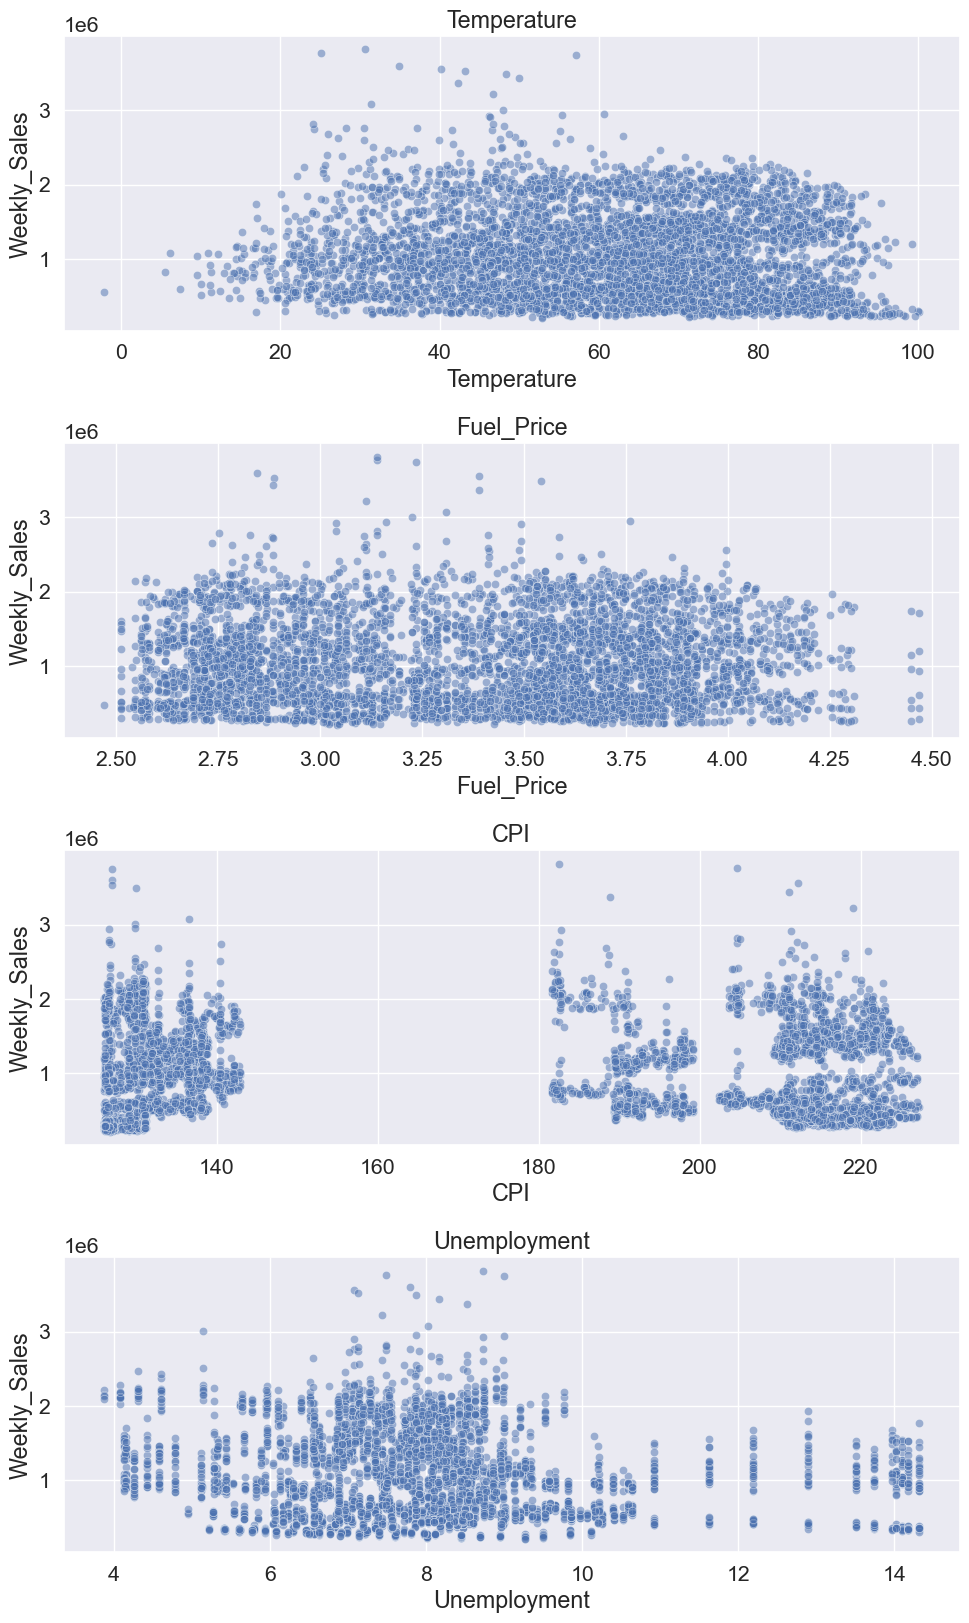

In [9]:
# Numerical features
num_feats = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

# Plot expenditure features
fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(num_feats):
    # Left plot
    ax = fig.add_subplot(5, 1, i + 1)
    sns.scatterplot(data=train, x=var_name, y="Weekly_Sales", axes=ax,alpha=0.5)
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

*Findings:*
Weekly sales are far lower (by over an order of magnitude) during holidays
CPI is noticable bimodal. Would be worth adding a feature for whether CPI is more or less than 160
Sales appear to be higher when temperature is 20-60 and when unemployment is lower though it isn't a clear trend.

Feature engineering

In [10]:
train["Day"] = train["Date"].str.split("-").str[0]
train["Month"] = train["Date"].str.split("-").str[1]
train["Year"] = train["Date"].str.split("-").str[2]
train["Weekday"] = pd.to_datetime(train["Date"], format="%d-%m-%Y").dt.dayofweek

test["Day"] = test["Date"].str.split("-").str[0]
test["Month"] = test["Date"].str.split("-").str[1]
test["Year"] = test["Date"].str.split("-").str[2]
test["Weekday"] = pd.to_datetime(test["Date"], format="%d-%m-%Y").dt.dayofweek

As standard, splitting date into individual attributes, in case one of day,month or year has a noticably higher effect on price


In [11]:
# New features
train["CPI_Level"] = np.nan
train.loc[train["CPI"] <= 160, "CPI_Level"] = 0
train.loc[(train["CPI"] > 160), "CPI_Level"] = 1

test["CPI_Level"] = np.nan
test.loc[test["CPI"] <= 160, "CPI_Level"] = 0
test.loc[(test["CPI"] > 160), "CPI_Level"] = 1

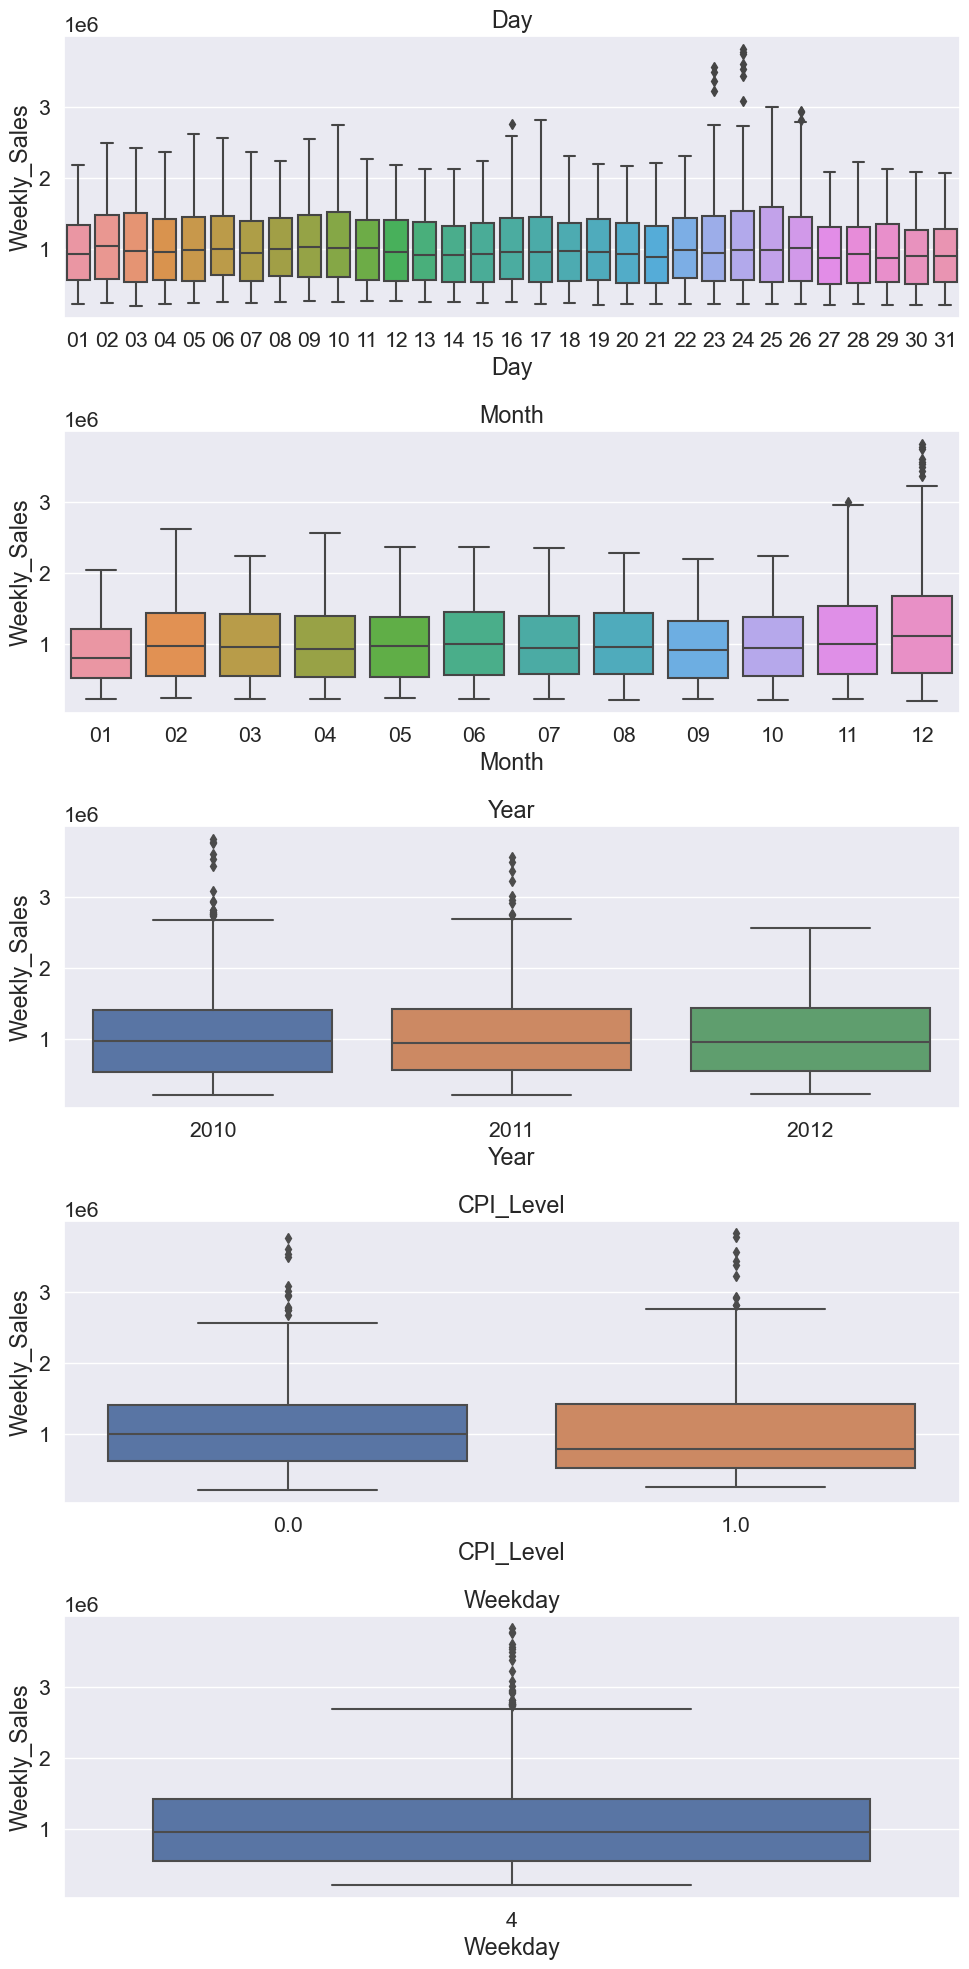

In [12]:

fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(["Day", "Month", "Year", "CPI_Level", "Weekday"]):
    ax = fig.add_subplot(5, 1, i + 1)
    sns.boxplot(data=train.sort_values(var_name), x=var_name, y="Weekly_Sales")
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

Sales are noticable higher in December and lower in January.
Data appears to have been recoreded on Fridays

In [13]:
train.drop(["Date"], axis=1, inplace=True)
test.drop(["Date"], axis=1, inplace=True)

X = train.copy().drop(["Weekly_Sales"], axis=1)
y = train.copy()["Weekly_Sales"]
X_test = test.copy().drop(["Weekly_Sales"], axis=1)
y_test = test.copy()["Weekly_Sales"]

In [14]:
# Indentify numerical and categorical columns
numerical_cols = [
    cname for cname in X.columns if X[cname].dtype in ["int64", "float64"]
]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False),
        )
    ]
)

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="passthrough",
)


# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.fit_transform(X_test)

# Print new shape
print("Training set shape:", X.shape)

Training set shape: (5148, 54)


In [15]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=0
)

In [16]:
# Classifiers
classifiers = {
    "RandomForest": RandomForestRegressor(random_state=0),
    "CatBoost": CatBoostRegressor(random_state=0, verbose=False),
}

# Grids for grid search

RF_grid = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    "max_depth": [4, 6, 8, 10, 12],
}

boosted_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 8, 12],
}


# Dictionary of all grids
grid = {
    "RandomForest": RF_grid,
    "CatBoost": boosted_grid,
}

In [17]:
i = 0
clf_best_params = classifiers.copy()
valid_scores = pd.DataFrame(
    {
        "Classifer": classifiers.keys(),
        "Validation accuracy": np.zeros(len(classifiers)),
        "Training time": np.zeros(len(classifiers)),
    }
)
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i, 1] = clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key] = clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i, 2] = np.round((stop - start) / 60, 2)

    print("Model:", key)
    print("Training time (mins):", valid_scores.iloc[i, 2])
    print("")
    i += 1

Model: RandomForest
Training time (mins): 2.7

Model: CatBoost
Training time (mins): 1.52



In [18]:
valid_scores

,Classifer,Validation accuracy,Training time
0,RandomForest,0.950487,2.70
1,CatBoost,0.973832,1.52


CatBoost has slightly better accuracy

In [19]:
# Show best parameters from grid search
clf_best_params

{'RandomForest': {'max_depth': 12, 'n_estimators': 300},
 'CatBoost': {'max_depth': 8, 'n_estimators': 200}}

In [20]:
# Classifiers
best_classifiers = {
    # "RandomForest" : RandomForestRegressor(**clf_best_params["RandomForest"], random_state=0),
    "CatBoost": CatBoostRegressor(
        **clf_best_params["CatBoost"], verbose=False, random_state=0
    ),
}

In [21]:
# Number of folds in cross validation
FOLDS = 10

preds = np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()

    # 10-fold cross validation
    cv = KFold(n_splits=FOLDS, shuffle=True, random_state=0)

    score = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):

        # Get training and validation sets

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict(X_test)
        score += clf.score(X_valid, y_valid)

    # Average accuracy
    score = score / FOLDS

    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print("Model:", key)
    print("Average validation accuracy:", np.round(100 * score, 2))
    print("Training time (mins):", np.round((stop - start) / 60, 2))
    print("")

# Ensemble predictions
preds = preds / (FOLDS * len(best_classifiers))

Model: CatBoost
Average validation accuracy: 97.38
Training time (mins): 0.22



Accuracy on the test set is still high so overfitting has been avoided.